## Confirm AppNums Count



In [2]:
import pandas as pd
import numpy as np

def count_application_numbers(metadata_file):
    # Read the metadata CSV
    df = pd.read_csv(metadata_file, low_memory=False)
    print(f"Total rows in metadata: {len(df)}")
    
    # Count rows with non-null extractedappno
    has_appno = df['extractedappno'].notna()
    print(f"Rows with application numbers: {has_appno.sum()}")
    
    # Count total unique application numbers
    total_appnos = 0
    unique_appnos = set()
    
    for appno in df[has_appno]['extractedappno']:
        if isinstance(appno, str):
            # Split by semicolon as they're semicolon-separated
            appnos = appno.split(';')
            total_appnos += len(appnos)
            unique_appnos.update(appnos)
    
    print(f"Total application numbers: {total_appnos}")
    print(f"Unique application numbers: {len(unique_appnos)}")

# Usage
count_application_numbers('../data/METADATA/echr_metadata.csv')

Total rows in metadata: 34090
Rows with application numbers: 24934
Total application numbers: 391297
Unique application numbers: 107460


## Confirm count of nodes and edges

In [9]:
from typing import Dict, List, Set, Tuple
import pandas as pd
import json
import os



def count_total_edges(edges_df: pd.DataFrame) -> int:
    """
    Count total number of edges in the network, considering multiple targets per entry.
    """
    total_edges = 0
    nan_rows = 0
    empty_refs = 0
    nan_in_refs = 0
    seen_edges = set()  # Track unique edges
    duplicate_count = 0
    examples_shown = 0  # Counter for duplicate examples
    
    for _, row in edges_df.iterrows():
        refs = row['references']
            
        # Handle string representation of list
        if isinstance(refs, str):
            try:
                refs_list = eval(refs)
            except:
                print(f"Warning: Could not process references: {refs}")
                continue
        else:
            refs_list = refs
            
        # Handle empty list
        if not refs_list:
            empty_refs += 1
            continue
            
        source = row['ecli']
        # Process each reference
        for ref in refs_list:
            if isinstance(ref, str) and not pd.isna(ref) and ref.startswith('ECLI:'):
                edge = (source, ref)
                if edge in seen_edges:
                    duplicate_count += 1
                    if examples_shown < 2:  # Show first 2 duplicates found
                        print(f"\nDuplicate edge found:")
                        print(f"Source: {source}")
                        print(f"Target: {ref}")
                        examples_shown += 1
                else:
                    seen_edges.add(edge)
                    total_edges += 1
        
        # Track if we found any NaN values in this reference list
        if any(pd.isna(ref) for ref in refs_list):
            nan_in_refs += 1
    
    # Print statistics
    print("\nEdge Count Statistics:")
    print(f"Total unique edges: {total_edges}")
    print(f"Duplicate edges found: {duplicate_count}")
    print(f"Rows with NaN references: {nan_rows}")
    print(f"Rows with empty references []: {empty_refs}")
    print(f"Rows containing NaN within references list: {nan_in_refs}")
    
    return total_edges

def analyze_nodes(nodes_df: pd.DataFrame) -> None:
    """Analyze the nodes dataframe for duplicates and missing ECLIs"""
    print("\n=== NODES STATISTICS ===")
    print(f"Total rows: {len(nodes_df)}")
    
    # Check for duplicate ECLIs
    duplicate_eclis = nodes_df[nodes_df['ecli'].duplicated(keep=False)]
    print(f"\n=== DUPLICATE ECLIs ===")
    print(f"Number of duplicate ECLIs: {len(duplicate_eclis)}")
    if len(duplicate_eclis) > 0:
        print("\nFirst few duplicates:")
        for ecli in duplicate_eclis['ecli'].unique()[:5]:
            dupes = nodes_df[nodes_df['ecli'] == ecli]
            print(f"\nECLI: {ecli}")
            print(f"Found {len(dupes)} times")
    
    # Check for missing ECLIs
    missing_eclis = nodes_df[nodes_df['ecli'].isna()]
    print(f"\n=== MISSING ECLIs ===")
    print(f"Number of rows with missing ECLIs: {len(missing_eclis)}")
    
    # Count unique ECLIs (excluding NaN)
    unique_eclis = nodes_df['ecli'].dropna().nunique()
    print(f"\n=== SUMMARY ===")
    print(f"Total rows: {len(nodes_df)}")
    print(f"Unique ECLIs: {unique_eclis}")
    print(f"Missing ECLIs: {len(missing_eclis)}")
    print(f"Duplicate ECLIs: {len(duplicate_eclis)}")

def analyze_network(nodes_df: pd.DataFrame, edges_df: pd.DataFrame) -> Tuple[pd.DataFrame, dict]:
    """
    Analyze and clean the network by:
    1. Counting and removing duplicate edges
    2. Removing edges with non-existent sources/targets
    3. Generating network statistics
    """
    # Convert nodes to set for O(1) lookup
    valid_nodes = set(nodes_df['ecli'].unique())
    
    # Statistics dictionary
    stats = {
        'original_edges': 0,
        'duplicate_edges': 0,
        'invalid_source_edges': 0,
        'invalid_target_edges': 0,
        'final_edges': 0,
        'nodes': len(valid_nodes),
        'isolated_nodes': 0
    }
    
    # Convert string representation of lists to actual lists, handling NaN values
    def safe_eval(x):
        if pd.isna(x):
            return []
        try:
            return eval(x)
        except:
            return []
            
    edges_df['references'] = edges_df['references'].apply(safe_eval)
    
    # Count original edges
    stats['original_edges'] = sum(len(refs) for refs in edges_df['references'])
    
    # Create set of all unique edges and track invalid edges
    unique_edges = set()
    cleaned_edges = []
    
    for _, row in edges_df.iterrows():
        source = row['ecli']
        if source not in valid_nodes:
            stats['invalid_source_edges'] += len(row['references'])
            continue
            
        valid_refs = []
        for target in row['references']:
            # Check for invalid targets
            if target not in valid_nodes:
                stats['invalid_target_edges'] += 1
                continue
                
            # Check for duplicates
            edge = (source, target)
            if edge in unique_edges:
                stats['duplicate_edges'] += 1
                continue
                
            unique_edges.add(edge)
            valid_refs.append(target)
        
        if valid_refs:
            cleaned_edges.append({
                'ecli': source,
                'references': valid_refs
            })
    
    # Create cleaned DataFrame
    cleaned_df = pd.DataFrame(cleaned_edges) if cleaned_edges else pd.DataFrame(columns=['ecli', 'references'])
    stats['final_edges'] = len(unique_edges)
    
    # Count isolated nodes (nodes with no edges)
    if not cleaned_df.empty:
        connected_nodes = set(cleaned_df['ecli']).union(
            *[set(refs) for refs in cleaned_df['references']]
        )
    else:
        connected_nodes = set()
    stats['isolated_nodes'] = len(valid_nodes - connected_nodes)
    
    # Calculate network density
    possible_edges = len(valid_nodes) * (len(valid_nodes) - 1)  # Directed graph
    stats['density'] = stats['final_edges'] / possible_edges if possible_edges > 0 else 0
    
    # Print statistics
    print("\nNetwork Statistics:")
    print(f"Nodes: {stats['nodes']}")
    print(f"Original Edges: {stats['original_edges']}")
    print(f"Duplicate Edges Removed: {stats['duplicate_edges']}")
    print(f"Invalid Source Edges Removed: {stats['invalid_source_edges']}")
    print(f"Invalid Target Edges Removed: {stats['invalid_target_edges']}")
    print(f"Final Edges: {stats['final_edges']}")
    print(f"Isolated Nodes: {stats['isolated_nodes']}")
    print(f"Network Density: {stats['density']:.6f}")
    
    return cleaned_df, stats


# Load data
edges_df = pd.read_csv('../data/METADATA/optimized/edges.csv')
nodes_df = pd.read_csv('../data/METADATA/optimized/nodes.csv')

# Calculate total edges
total_edges = count_total_edges(edges_df)

# Analyze nodes
analyze_nodes(nodes_df)


print(f'Total number of nodes: {len(nodes_df)}')
print(f"Total number of edges: {total_edges}")

cleaned_edges, stats = analyze_network(nodes_df, edges_df)





Edge Count Statistics:
Total unique edges: 232002
Duplicate edges found: 0
Rows with NaN references: 0
Rows with empty references []: 6660
Rows containing NaN within references list: 0

=== NODES STATISTICS ===
Total rows: 27801

=== DUPLICATE ECLIs ===
Number of duplicate ECLIs: 0

=== MISSING ECLIs ===
Number of rows with missing ECLIs: 0

=== SUMMARY ===
Total rows: 27801
Unique ECLIs: 27801
Missing ECLIs: 0
Duplicate ECLIs: 0
Total number of nodes: 27801
Total number of edges: 232002

Network Statistics:
Nodes: 27801
Original Edges: 232002
Duplicate Edges Removed: 0
Invalid Source Edges Removed: 0
Invalid Target Edges Removed: 0
Final Edges: 232002
Isolated Nodes: 4495
Network Density: 0.000300


/var/folders/26/0sr3rdx53314n7l3fzj55k6r0000gn/T/ipykernel_93543/802445442.py:23: DtypeWarning: Columns (9,16) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(metadata_path)



=== BASIC STATISTICS ===
Total missing references: 207038
Unique source ECLIs: 18131
Total unique failed edges: 205643
Unique missing references: 85999

=== REFERENCE TYPE DISTRIBUTION ===
reference_type
extracted_appno    130611
case_name           40196
scl_appno           36230
reference_type          1
Name: count, dtype: int64

=== TOP 10 MOST FREQUENTLY MISSING REFERENCES ===
missing_reference
Application number: 42525/07    998
Application number: 60800/08    998
Application number: 17153/11    677
Application number: 41963/98    540
Application number: 39221/98    539
Application number: 40792/10    516
Application number: 43577/98    508
Application number: 43579/98    508
Application number: 57220/00    452
Application number: 16064/90    409
Name: count, dtype: int64

=== TOP 10 SOURCES WITH MOST MISSING REFERENCES ===
source_ecli
ECLI:CE:ECHR:2017:1012JUD004685213    12167
ECLI:CE:ECHR:2015:0210JUD005198708     1029
ECLI:CE:ECHR:2017:1010JUD001331208      842
ECLI:CE:ECHR:

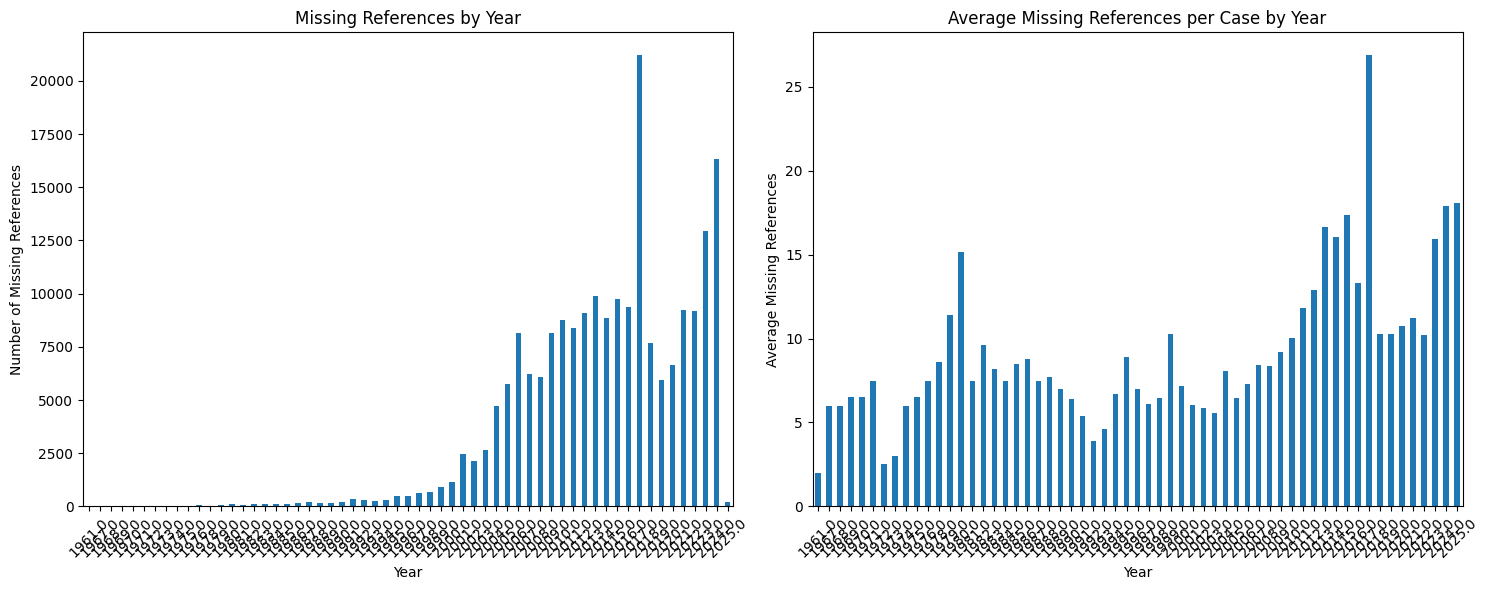

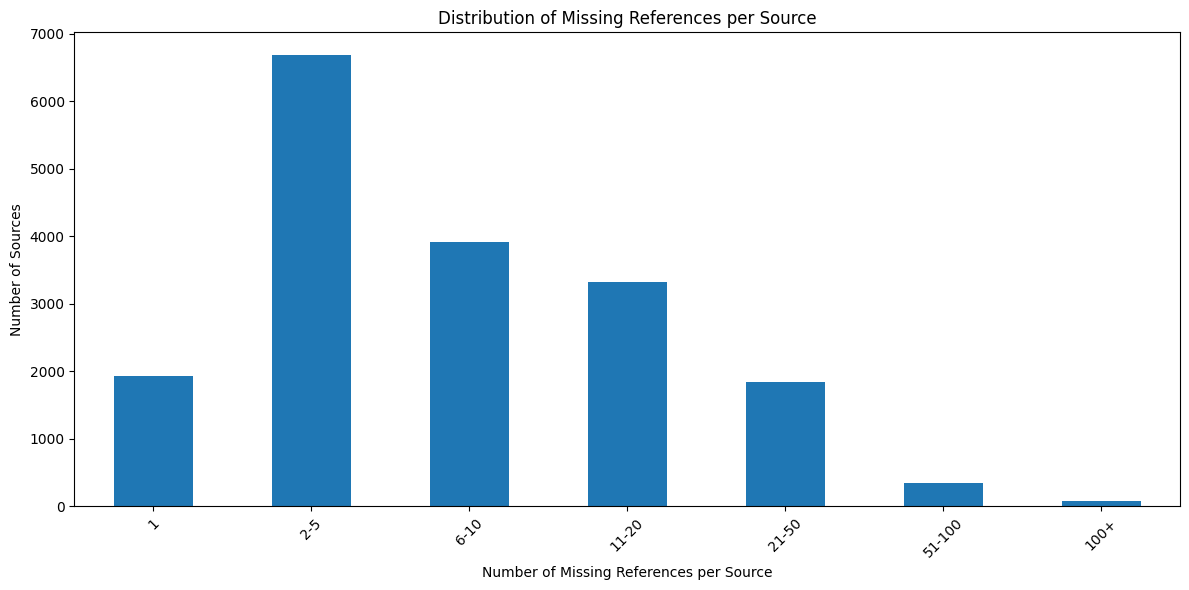

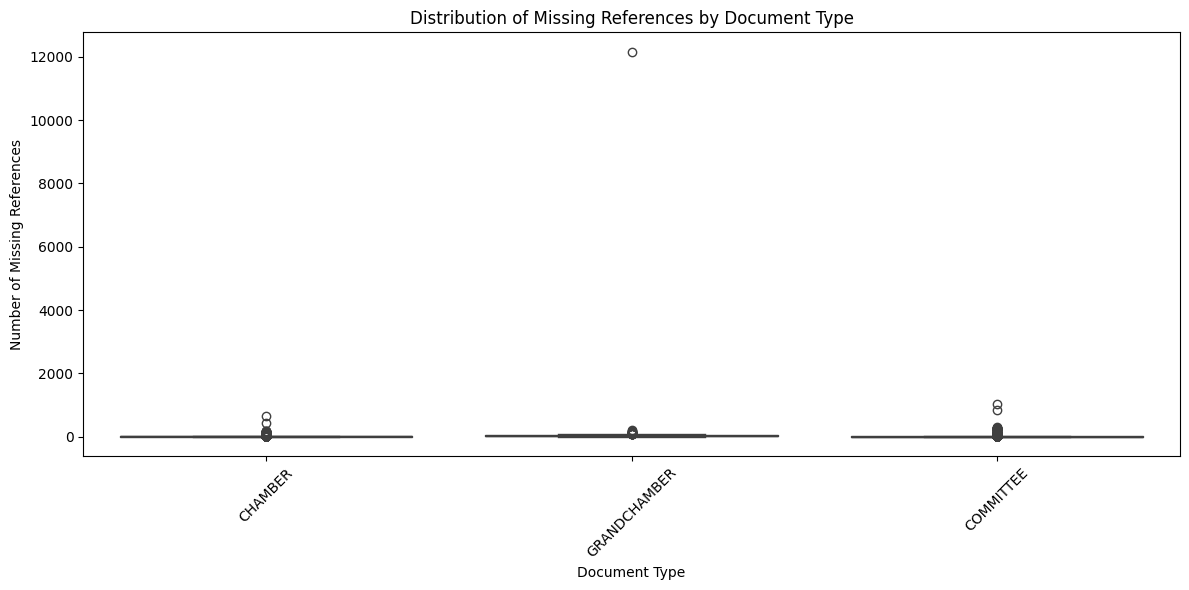

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import Dict, List
import re
import os


def extract_year_from_ecli(ecli: str) -> int:
    """Extract year from ECLI string"""
    try:
        return int(re.search(r':(\d{4}):', ecli).group(1))
    except (AttributeError, ValueError):
        return None

def analyze_missing_cases(missing_cases_path: str, metadata_path: str) -> None:
    """
    Analyze missing cases with temporal patterns and metadata context
    """
    # Read files
    df = pd.read_csv(missing_cases_path, names=['source_ecli', 'missing_reference', 'reference_type'])
    metadata = pd.read_csv(metadata_path)
    failed_edges = df.drop_duplicates().to_dict('records')
    
    # PART 1: Basic Statistics and Distribution
    print("\n=== BASIC STATISTICS ===")
    print(f"Total missing references: {len(df)}")
    print(f"Unique source ECLIs: {df['source_ecli'].nunique()}")
    print(f'Total unique failed edges: {len(failed_edges)}')
    print(f"Unique missing references: {df['missing_reference'].nunique()}")
    
    print("\n=== REFERENCE TYPE DISTRIBUTION ===")
    type_counts = df['reference_type'].value_counts()
    print(type_counts)
    
    print("\n=== TOP 10 MOST FREQUENTLY MISSING REFERENCES ===")
    ref_counts = df['missing_reference'].value_counts().head(10)
    print(ref_counts)
    
    print("\n=== TOP 10 SOURCES WITH MOST MISSING REFERENCES ===")
    source_counts = df['source_ecli'].value_counts().head(10)
    print(source_counts)
    
    print("\n=== APPLICATION NUMBER STATISTICS ===")
    app_numbers = df[df['missing_reference'].str.contains('Application number:', na=False)]
    print(f"Total missing application numbers: {len(app_numbers)}")
    print(f"Unique missing application numbers: {app_numbers['missing_reference'].nunique()}")
    
    print("\n=== CASE NAME STATISTICS ===")
    case_names = df[df['reference_type'] == 'case_name']
    print(f"Total missing case names: {len(case_names)}")
    print(f"Unique missing case names: {case_names['missing_reference'].nunique()}")
    
    # PART 2: Temporal and Metadata Analysis
    df['year'] = df['source_ecli'].apply(extract_year_from_ecli)
    
    print("\n=== TEMPORAL ANALYSIS ===")
    year_counts = df['year'].value_counts().sort_index()
    print("\nMissing references by year:")
    print(year_counts)
    
    refs_per_case_by_year = df.groupby('year')['source_ecli'].nunique()
    avg_refs_by_year = df.groupby('year').size() / refs_per_case_by_year
    print("\nAverage missing references per case by year:")
    print(avg_refs_by_year.round(2))
    
    print("\n=== DOCUMENT TYPE ANALYSIS ===")
    df_with_meta = df.merge(
        metadata[['ecli', 'doctypebranch', 'importance', 'languageisocode']], 
        left_on='source_ecli', 
        right_on='ecli',
        how='left'
    )
    
    print("\nMissing references by document type:")
    print(df_with_meta['doctypebranch'].value_counts())
    
    print("\nMissing references by importance level:")
    print(df_with_meta['importance'].value_counts())
    
    print("\nMissing references by language:")
    print(df_with_meta['languageisocode'].value_counts())
    
    # PART 3: Distribution Analysis
    refs_per_source = df.groupby('source_ecli').size()
    print("\n=== MISSING REFERENCES PER SOURCE ANALYSIS ===")
    print(f"Number of sources with missing references: {len(refs_per_source)}")
    
    bins = [0, 1, 5, 10, 20, 50, 100, float('inf')]
    labels = ['1', '2-5', '6-10', '11-20', '21-50', '51-100', '100+']
    binned_counts = pd.cut(refs_per_source, bins=bins, labels=labels).value_counts().sort_index()
    
    print("\nDistribution of missing references:")
    print("Number of missing refs | Number of sources")
    print("-" * 40)
    for label, count in binned_counts.items():
        print(f"{label:16} | {count:>6} sources")
    
        # PART 4: Extreme Cases Analysis
    print("\n=== ANALYSIS OF EXTREME CASES (>100 missing refs) ===")
    extreme_cases = refs_per_source[refs_per_source > 100]
    
    # Create a clean metadata lookup by removing duplicates
    clean_metadata = metadata.drop_duplicates(subset=['ecli'], keep='first')
    metadata_lookup = clean_metadata.set_index('ecli')
    
    # Create extreme cases analysis DataFrame
    extreme_data = []
    for ecli in extreme_cases.index:
        if ecli in metadata_lookup.index:
            extreme_data.append({
                'ecli': ecli,
                'missing_refs': extreme_cases[ecli],
                'doctypebranch': metadata_lookup.loc[ecli, 'doctypebranch'],
                'importance': metadata_lookup.loc[ecli, 'importance']
            })
        else:
            print(f"Warning: ECLI {ecli} not found in metadata")
    
    extreme_analysis = pd.DataFrame(extreme_data)
    if not extreme_analysis.empty:
        extreme_analysis = extreme_analysis.sort_values('missing_refs', ascending=False)
        extreme_analysis.to_csv('analysis/extreme_cases_analysis.csv', index=False)
        
        # Print analysis
        for _, row in extreme_analysis.iterrows():
            print(f"\nCase: {row['ecli']}")
            print(f"Missing references: {row['missing_refs']}")
            print(f"Document type: {row['doctypebranch']}")
            print(f"Importance: {row['importance']}")
            
            case_refs = df[df['source_ecli'] == row['ecli']]
            print("\nReference types:")
            print(case_refs['reference_type'].value_counts())
    
    # Create output directory
    os.makedirs('analysis', exist_ok=True)
    
    # Visualizations
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    year_counts.plot(kind='bar')
    plt.title('Missing References by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Missing References')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    avg_refs_by_year.plot(kind='bar')
    plt.title('Average Missing References per Case by Year')
    plt.xlabel('Year')
    plt.ylabel('Average Missing References')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('analysis/temporal_analysis.png')
    
    # Distribution visualization
    plt.figure(figsize=(12, 6))
    binned_counts.plot(kind='bar')
    plt.title('Distribution of Missing References per Source')
    plt.xlabel('Number of Missing References per Source')
    plt.ylabel('Number of Sources')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('analysis/missing_refs_distribution.png')
    
    # Document type analysis
    plt.figure(figsize=(12, 6))
    
    # Calculate refs per source first
    refs_by_source = df_with_meta.groupby(['source_ecli', 'doctypebranch']).size().reset_index(name='count')
    
    # Create boxplot
    sns.boxplot(data=refs_by_source, x='doctypebranch', y='count')
    plt.title('Distribution of Missing References by Document Type')
    plt.xlabel('Document Type')
    plt.ylabel('Number of Missing References')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('analysis/doctype_analysis.png')
    
    # Save detailed analyses
    refs_per_source.sort_values(ascending=False).to_csv(
        'analysis/missing_refs_per_source.csv',
        header=['missing_ref_count']
    )




analyze_missing_cases('../data/METADATA/optimized/missing_cases.csv', '../data/METADATA/echr_metadata.csv')

## Map edges

In [ ]:
import numpy as np
import pandas as pd
import re
import dateparser
from echr_extractor.clean_ref import clean_pattern



def open_metadata(PATH_metadata):
    """
    Finds the ECHR metadata file and loads it into a dataframe
    
    param filename_metadata: string with path to metadata
    """
    try:
        df = pd.read_csv(PATH_metadata)  # change hard coded path
        print(df.columns)
        return df
    except FileNotFoundError:
        print("File not found. Please check the path to the metadata file.")
        return False

def concat_metadata(df):
    agg_func = {'itemid' : 'first', 'appno' : 'first', 'article' : 'first', 'conclusion' : 'first' , 'docname' : 'first' , 'doctype' : 'first',
                'doctypebranch' : 'first', 'ecli' : 'first', 'importance' : 'first', 'judgementdate' : 'first', 'languageisocode' : ', '.join, 'originatingbody' : 'first',
                'violation' : 'first', 'nonviolation' : 'first', 'extractedappno' : 'first', 'scl' : 'first'}
    new_df = df.groupby('ecli').agg(agg_func)
    print(new_df)
    return new_df

def get_language_from_metadata(df):
    df = concat_metadata(df)
    df.to_json('langisocode-nodes.json', orient="records")

def metadata_to_nodesedgeslist(df):
    """
    Returns a dataframe where column 'article' only contains a certain article

    param df: the complete dataframe from the metadata
    """
    
    return df


def retrieve_nodes_list(df):
    """
    Returns a dataframe where 'ecli' is moved to the first column.
    
    param df: the dataframe after article filter
    """
    df = metadata_to_nodesedgeslist(df)
    # Instead of dropping first column blindly, keep appno
    df_copy = df.copy()
    
    # Move ecli to first position
    col = df_copy.pop("ecli")
    df_copy.insert(0, col.name, col)
    
    return df_copy


def retrieve_edges_list(df, df_unfiltered):
    """
    Returns a dataframe consisting of 2 columns 'ecli' and 'reference' which
    indicate a reference link between cases.

    params:
    df -- the node list extracted from the metadata
    df_unfiltered -- the complete dataframe from the metadata
    """
    edges = pd.DataFrame(columns=['ecli', 'references'])

    count = 0
    tot_num_refs = 0
    missing_cases = []
    for index, item in df.iterrows():
        eclis = []
        app_number = []
        extracted_appnos = []
        if item.extractedappno is not np.nan:
            extracted_appnos = item.extractedappno.split(';') 

        if item.scl is not np.nan:
            """
            Split the references from the scl column i nto a list of references.

            Example:
            references in string: "Ali v. Switzerland, 5 August 1998, § 32, Reports of Judgments and 
            Decisions 1998-V;Sevgi Erdogan v. Turkey (striking out), no. 28492/95, 29 April 2003"

            ["Ali v. Switzerland, 5 August 1998, § 32, Reports of Judgments and 
            Decisions 1998-V", "Sevgi Erdogan v. Turkey (striking out), no. 
            28492/95, 29 April 2003"]
            """
            ref_list = item.scl.split(';')
            new_ref_list = []
            for ref in ref_list:
                ref = re.sub('\n', '', ref)
                new_ref_list.append(ref)

            tot_num_refs = tot_num_refs + len(ref_list)

            for ref in new_ref_list:
                app_number = re.findall("[0-9]{3,5}\/[0-9]{2}", ref) ################
                if len(extracted_appnos) > 0:
                    app_number = app_number + extracted_appnos
                # app_number = app_number + extracted_appnos
                app_number = set(app_number)
                
                if len(app_number) > 0:
                    # get dataframe with all possible cases by application number
                    if len(app_number) > 1:
                        app_number = [';'.join(app_number)]
                    case = lookup_app_number(app_number, df_unfiltered)
                else: # if no application number in reference
                    # get dataframe with all possible cases by casename
                    case = lookup_casename(ref, df_unfiltered)

                if len(case) == 0:
                    case = lookup_casename(ref, df_unfiltered)

                components = ref.split(',')
                # get the year of case
                year_from_ref = get_year_from_ref(components)

                # remove cases in different language than reference
                for id, it in case.iterrows():
                    if 'v.' in components[0]:
                        lang = 'ENG'
                    else:
                        lang = 'FRE'

                    if lang not in it.languageisocode:
                        case = case[case['languageisocode'].str.contains(lang, regex=False, flags=re.IGNORECASE)]

                for id, i in case.iterrows():
                    if i.judgementdate is np.nan:
                        continue
                    date = dateparser.parse(i.judgementdate)
                    year_from_case = date.year

                    if year_from_case - year_from_ref == 0:
                        case = case[case['judgementdate'].str.contains(str(year_from_ref), regex=False, flags=re.IGNORECASE)]

                #case = metadata_to_nodesedgeslist(case)

                if len(case) > 0:
                    if len(case) > 3:
                        print("stop")
                    for _,row in case.iterrows():
                        eclis.append(row.ecli)
                else:
                    count = count + 1
                    missing_cases.append(ref)

            eclis = set(eclis)

            #add ecli to edges list
            if len(eclis) == 0:
                continue
            else:
                edges = pd.concat(
                    [edges, pd.DataFrame.from_records([{'ecli': item.ecli, 'references': list(eclis)}])])

    print("num missed cases: ", count)
    print("total num of refs: ", tot_num_refs)
    missing_cases_set = set(missing_cases)
    missing_cases = list(missing_cases_set)
    
    # Store missing references
    missing_df = pd.DataFrame(missing_cases)
    edges = edges.groupby('ecli', as_index=False).agg({'references' : 'sum'})
    return edges, missing_df

def lookup_app_number(pattern, df):
    """
    Returns a list with rows containing the cases linked to the found app numbers.
    """
    print(f"Looking up app numbers: {pattern}")
    row = df.loc[df['appno'].isin(pattern)]

    if row.empty:
        return pd.DataFrame()
    elif row.shape[0] > 1:
        return row
    else:
        return row


def lookup_casename(ref, df):
    """
    Process the reference for lookup in metadata.
    Returns the rows corresponding to the cases.

    - Example of the processing (2 variants) -

    Original reference from scl:
    - Hentrich v. France, 22 September 1994, § 42, Series A no. 296-A
    - Eur. Court H.R. James and Others judgment of 21 February 1986,
    Series A no. 98, p. 46, para. 81

    Split on ',' and take first item:
    Hentrich v. France
    Eur. Court H.R. James and Others judgment of 21 February 1986

    If certain pattern from CLEAN_REF in case name, then remove:
    Eur. Court H.R. James and Others judgment of 21 February 1986 -->
        James and Others

    Change name to upper case and add additional text to match metadata:
    Hentrich v. France --> CASE OF HENTRICH V. FRANCE
    James and Others --> CASE OF JAMES AND OTHERS
    """
    name = get_casename(ref)
    
    # DEV note: In case, add more patterns to clean_ref.py in future
    patterns = clean_pattern

    uptext = name.upper()

    if 'NO.' in uptext:
        uptext = uptext.replace('NO.', 'No.')

    if 'BV' in uptext:
        uptext = uptext.replace('BV', 'B.V.')

    if 'v.' in name:
        uptext = uptext.replace('V.', 'v.')
        lang = 'ENG'
    else:
        uptext = uptext.replace('C.', 'c.')
        lang = 'FRE'

    for pattern in patterns:
        uptext = re.sub(pattern, '', uptext)

    uptext = re.sub(r'\[.*', "", uptext)
    uptext = uptext.strip()
    row = df[df['docname'].str.contains(uptext, regex=False, flags=re.IGNORECASE)]

    # if len(row) == 0:
    #     print("no cases matched: ", name)

    return row

def get_casename(ref):
    count = 0
    if 'v.' in ref:
        slice_at_versus = ref.split('v.')  # skip if typo (count how many)
    elif 'c.' in ref:
        slice_at_versus = ref.split('c.')
    else:
        count = count + 1
        name = ref.split(',')
        return name[0]

    num_commas = slice_at_versus[0].count(',')

    if num_commas > 0:
        num_commas = num_commas + 1
        name = ",".join(ref.split(",", num_commas)[:num_commas])
    else:
        name = ref.split(',')
        return name[0]
    return name

def get_year_from_ref(ref):
    for component in ref:
        if '§' in component:
            continue
        component = re.sub('judgment of ', "", component)
        if dateparser.parse(component) is not None:
            date = dateparser.parse(component)
        elif ("ECHR" in component or "CEDH" in component):
            if ("ECHR" in component or "CEDH" in component):
                date = re.sub('ECHR ', '', component)
                date = re.sub('CEDH ', '', date)
                date = date.strip()
                date = re.sub('-.*', '', date)
                date = re.sub('\s.*', '', date)
                date = dateparser.parse(date)
   
    try:
        return date.year
    except:
        return 0



def echr_nodes_edges(metadata_path):
    """
    Create nodes and edges list for the ECHR data.
    """
    print('\n--- COLLECTING METADATA ---\n')
    data = open_metadata(metadata_path)

    print('\n--- EXTRACTING NODES LIST ---\n')
    nodes = retrieve_nodes_list(data)
    print(f"Number of nodes: {len(nodes)}")
    # get_language_from_metadata(nodes)

    print('\n--- EXTRACTING EDGES LIST ---\n')
    edges, missing_df = retrieve_edges_list(nodes, data)

    return nodes, edges, missing_df

In [ ]:
nodes, edges, missing_df = echr_nodes_edges('../data/METADATA/echr_metadata.csv')

print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")
print(f"Number of missing cases: {len(missing_df)}")

# Save to CSV files
print("\n--- SAVING TO CSV ---\n")
nodes.to_csv('../data/METADATA/nodes.csv', index=False)
edges.to_csv('../data/METADATA/edges.csv', index=False) 
missing_df.to_csv('../data/METADATA/missing_cases.csv', index=False)

print("Files saved successfully to ../data/METADATA/")

